In [2]:
%%capture
!pip install fairlearn

In [3]:
#@markdown Load modules
import numpy as np
from IPython.display import display, Markdown, Latex
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.adversarial import AdversarialFairnessClassifier
from fairlearn.metrics import MetricFrame
import fairlearn.datasets as fdata
from fairlearn.metrics import (demographic_parity_difference, demographic_parity_ratio, 
                               selection_rate_difference, false_negative_rate_difference, 
                               false_positive_rate_difference, equalized_odds_ratio,
                               false_negative_rate, false_positive_rate)

# Load and preprocess the data

In [4]:
#@markdown Load and read about the dataset.
# get datast from fairlearn and show description
dataset = fdata.fetch_diabetes_hospital()

display(Markdown(dataset.DESCR))

# save dataframe and features
x_raw = dataset.data
# y_raw = np.array(dataset.target)
feature_names = dataset.feature_names

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


The "Diabetes 130-Hospitals" dataset represents 10 years of clinical care at 130 U.S. hospitals and delivery networks, collected from 1999 to 2008. Each record represents the hospital admission record for a patient diagnosed with diabetes whose stay lasted between one to fourteen days. The features describing each encounter include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information, as well as whether the patient was readmitted after release, and whether the readmission occurred within 30 days of the release.

The original "Diabetes 130-Hospitals" dataset was collected by Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore in 2014.

This version of the dataset was derived by the Fairlearn team for the SciPy 2021 tutorial "Fairness in AI Systems: From social context to practice using Fairlearn". In this version, the target variable "readmitted" is binarized into whether the patient was re-admitted within thirty days. The full dataset pre-processing script can be found on GitHub: https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/preprocess.py

Downloaded from openml.org.

You can read more about the dataset [here](https://fairlearn.org/main/user_guide/datasets/diabetes_hospital_data.html). In this description, we see that two features, `readmitted` and `readmit_binary`, are other representations of the same outcome, so we drop them from the set of predictors.

In [5]:
#@markdown Down sample to make runtimes reasonable
x_raw = x_raw.sample(frac=0.1, random_state=123)

In [6]:
y_raw = x_raw['readmit_binary']
x_raw = x_raw.drop(columns=['readmitted', 'readmit_binary'])
feature_names = feature_names[:-2]

In [7]:
#@markdown Look at the first few rows of the data.
x_raw.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,max_glu_serum,A1Cresult,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days
65884,Caucasian,Male,Over 60 years,Discharged to Home,Emergency,3,Missing,49,6,27,...,None,None,Up,Ch,Yes,False,False,False,True,False
86278,Caucasian,Female,Over 60 years,Other,Referral,5,Missing,57,0,21,...,None,None,No,Ch,Yes,True,False,False,True,False
30000,Caucasian,Male,30-60 years,Discharged to Home,Other,4,Other,37,2,9,...,None,None,No,No,No,False,False,False,False,False
51185,Caucasian,Male,30-60 years,Other,Other,9,InternalMedicine,61,6,27,...,None,>8,No,Ch,Yes,False,False,True,False,True
53902,Caucasian,Female,30-60 years,Discharged to Home,Referral,7,Other,23,0,13,...,None,None,No,No,Yes,True,False,True,True,False


## data inspectation 

In [8]:
#@markdown drop the rows with 'Unknown/Invalid' values for gender

# drop these 3 rows
print(x_raw.shape)
rows_to_keep = x_raw.gender != 'Unknown/Invalid'
x_raw = x_raw[rows_to_keep]
y_raw = y_raw[rows_to_keep]
print(x_raw.shape)

(10177, 22)
(10177, 22)


In [9]:
#@markdown
unique_feature_values = x_raw.apply(np.unique, axis=0)
unique_feature_values

race                        [AfricanAmerican, Asian, Caucasian, Hispanic, ...
gender                                                         [Female, Male]
age                         [30 years or younger, 30-60 years, Over 60 years]
discharge_disposition_id                          [Discharged to Home, Other]
admission_source_id                              [Emergency, Other, Referral]
time_in_hospital              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
medical_specialty           [Cardiology, Emergency/Trauma, Family/GeneralP...
num_lab_procedures          [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
num_procedures                                          [0, 1, 2, 3, 4, 5, 6]
num_medications             [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
primary_diagnosis           [Diabetes, Genitourinary Issues, Musculoskelet...
number_diagnoses                  [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 15, 16]
max_glu_serum                                        [>200, >300

In [10]:
#@markdown
binary_features = unique_feature_values.index[[len(x) == 2 for x in unique_feature_values]].values
print(f'Binary features: {binary_features}')
categorical_features = unique_feature_values.index[[len(x) > 2 and isinstance(x[0], str) for x in unique_feature_values]].values
print(f'Categorical features: {categorical_features}')

Binary features: ['gender' 'discharge_disposition_id' 'change' 'diabetesMed' 'medicare'
 'medicaid' 'had_emergency' 'had_inpatient_days' 'had_outpatient_days']
Categorical features: ['race' 'age' 'admission_source_id' 'medical_specialty'
 'primary_diagnosis' 'max_glu_serum' 'A1Cresult' 'insulin']


In [11]:
#@markdown standardize data types 
for col_name in feature_names:
    if col_name in categorical_features:
        x_raw[col_name] = x_raw[col_name].astype('category')
    elif col_name in binary_features:  # redundant for clarity
        # turn into int column
        integer_col = (x_raw[col_name] == unique_feature_values[col_name][0]).astype(int)
        new_name = f'{col_name}_{unique_feature_values[col_name][0]}'
        x_raw[new_name] = integer_col
        x_raw.drop(columns=[col_name], inplace=True) 

In [12]:
#@markdown
%%capture
x_raw.apply(np.unique, axis=0)

In [13]:
x_raw.dtypes

race                                           category
age                                            category
admission_source_id                            category
time_in_hospital                                  int64
medical_specialty                              category
num_lab_procedures                                int64
num_procedures                                    int64
num_medications                                   int64
primary_diagnosis                              category
number_diagnoses                                  int64
max_glu_serum                                  category
A1Cresult                                      category
insulin                                        category
gender_Female                                     int64
discharge_disposition_id_Discharged to Home       int64
change_Ch                                         int64
diabetesMed_No                                    int64
medicare_False                                  

In [14]:
#@markdown One-hot encode categorical features
x_numeric = pd.get_dummies(x_raw)
display(x_numeric.head())

# get one-hot and numeric column names
numeric_cols = x_numeric.dtypes.index[x_numeric.dtypes == 'float64'].values
one_hot_cols = x_numeric.dtypes.index[x_numeric.dtypes != 'float64'].values

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,gender_Female,discharge_disposition_id_Discharged to Home,change_Ch,diabetesMed_No,medicare_False,...,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up
65884,3,49,6,27,9,0,1,1,0,1,...,1,0,0,0,1,0,0,0,0,1
86278,5,57,0,21,9,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
30000,4,37,2,9,5,0,1,0,1,1,...,1,0,0,0,1,0,0,1,0,0
51185,9,61,6,27,9,0,0,1,0,1,...,1,0,0,1,0,0,0,1,0,0
53902,7,23,0,13,7,1,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0


 # TODO: Split train, test data 80 train / 20 test 


In [55]:
# write your code here 

X_train, X_test, y_train, y_test = train_test_split(x_numeric, y_raw, test_size=0.2, random_state=42)

#test_size 20 percent as parameter

# Problem 2, Part (a) 
### **Train a baseline Random Forest (RF) (sklearn RandomForestClassifier) model and report metrics**

### Train a random forest model - Baseline

In [69]:
# write your code here 
# initialize a model with RandomForestClassifier 
n_estimators = 1

# train the model with the training data split
randomf_clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

# Train the classifier using the training data
randomf_clf.fit(X_train, y_train)



RandomForestClassifier(n_estimators=1, random_state=42)

### Report metrics

Calculate metrics with Fairlearn MetricFrame


0.5260314341846758


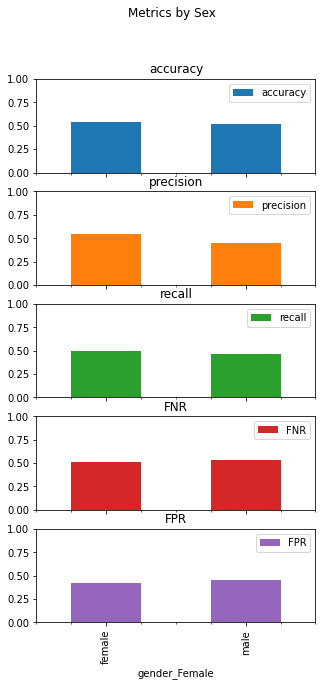

In [70]:
# write your code here 

# get model's prediction for the test set
y_pred_baseline = randomf_clf.predict(X_test)

sensitive_feature = X_test['gender_Female'].replace({1:'female', 0:'male'})

#evaluation metrics
metrics = {'accuracy': accuracy_score,
           'precision': precision_score,
           'recall':recall_score,
           'FNR': false_negative_rate,
           'FPR': false_positive_rate,
           }

#metric_dict = {}
#sample_params = {}

grouped_by_sex = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred_baseline,
                             sensitive_features = sensitive_feature)

grouped_by_sex.by_group.plot.bar(
    subplots=True, 
    figsize=(5, 10), 
    ylim=[0,1],
    title="Metrics by Sex",
    )

print(grouped_by_sex.overall[0])
plt.show()

Print Results

In [71]:
grouped_by_sex.overall

accuracy     0.526031
precision    0.505920
recall       0.481557
FNR          0.518443
FPR          0.433019
dtype: float64

In [72]:
grouped_by_sex.by_group

,accuracy,precision,recall,FNR,FPR
gender_Female,,,,,
female,0.535965,0.549133,0.491379,0.508621,0.417857
male,0.513393,0.451220,0.467172,0.532828,0.450000


In [73]:
#now we show additional metrics
false_negative_rate_diff = false_negative_rate_difference(y_test, y_pred_baseline, sensitive_features= X_test['gender_Female'])
print(f'false_negative_rate_diff: {false_negative_rate_diff:.4f}')

false_positive_rate_diff = false_positive_rate_difference(y_test, y_pred_baseline, sensitive_features= X_test['gender_Female'])
print(f'false_positive_rate_diff: {false_negative_rate_diff:.4f}')

demo_parity_ratio = demographic_parity_ratio(y_test, y_pred_baseline, sensitive_features= X_test['gender_Female'])
print(f'demographic_parity_ratio: {demo_parity_ratio:.4f}')

equal_odds_ratio = equalized_odds_ratio(y_test, y_pred_baseline, sensitive_features= X_test['gender_Female'])
print(f'equalized_odds_ratio: {equal_odds_ratio:.4f}')

selection_rate_diff = selection_rate_difference(y_test, y_pred_baseline, sensitive_features= X_test['gender_Female'])
print(f'selection_rate_difference: {selection_rate_diff:.4f}')

false_negative_rate_diff: 0.0242
false_positive_rate_diff: 0.0242
demographic_parity_ratio: 0.9949
equalized_odds_ratio: 0.9286
selection_rate_difference: 0.0023


In [80]:
untuned_forest = {'accuracy':grouped_by_sex.overall['accuracy'],
                'precision':grouped_by_sex.overall['precision'],
                'recall':grouped_by_sex.overall['recall'],
                'FNR':grouped_by_sex.overall['FNR'],
                'FPR':grouped_by_sex.overall['FPR'],
                
                'false_negative_rate_difference':false_negative_rate_diff,
                'false_positive_rate_difference':false_positive_rate_diff,
                'demographic_parity_ratio':demo_parity_ratio,
                'equalized_odds_ratio':equal_odds_ratio,
                'selection_rate_difference':selection_rate_diff}

In [81]:
untuned_forest

{'accuracy': 0.5260314341846758,
 'precision': 0.5059203444564048,
 'recall': 0.48155737704918034,
 'FNR': 0.5184426229508197,
 'FPR': 0.4330188679245283,
 'false_negative_rate_difference': 0.024207593173110498,
 'false_positive_rate_difference': 0.03214285714285714,
 'demographic_parity_ratio': 0.9949165596919128,
 'equalized_odds_ratio': 0.9285714285714286,
 'selection_rate_difference': 0.002326127819548829}

##DISCUSS

very low accuracy across groups, 0.50 range is not something you want to rely on, so this model without tunning is not preforming properly. Moreover, in regards to the rest of the metrics, there is a positive bias for being a man, having a higher FPR than women. So even though it might have improved bias, it is still considerable and something to handle



# Problem 2, Part (b)

Train another classifier with the following value of hyperparameters

In [82]:
# write your code here 
n_estimators = 1000
max_depth = 10

randomf_clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth, random_state=42)

# Train the classifier using the training data
randomf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=42)

Calculate metrics with Fairlearn MetricFrame
and print the results

0.6139489194499018


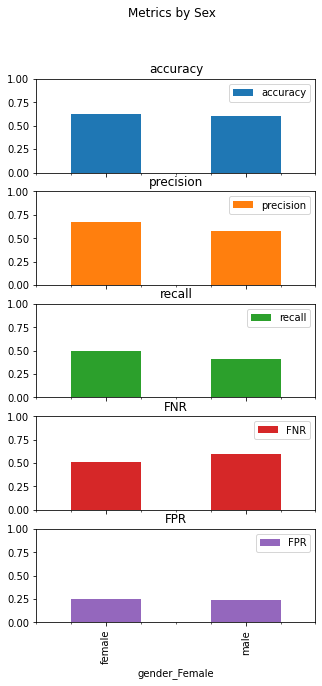

In [83]:
# write your code here 

# get model's prediction for the test set
y_pred_baseline = randomf_clf.predict(X_test)

sensitive_feature = X_test['gender_Female'].replace({1:'female', 0:'male'})

#evaluation metrics
metrics = {'accuracy': accuracy_score,
           'precision': precision_score,
           'recall':recall_score,
           'FNR': false_negative_rate,
           'FPR': false_positive_rate,
           }

#metric_dict = {}
#sample_params = {}

grouped_by_sex = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred_baseline,
                             sensitive_features = sensitive_feature)

grouped_by_sex.by_group.plot.bar(
    subplots=True, 
    figsize=(5, 10), 
    ylim=[0,1],
    title="Metrics by Sex",
    )

print(grouped_by_sex.overall[0])
plt.show()

In [84]:
grouped_by_sex.overall

accuracy     0.613949
precision    0.635328
recall       0.456967
FNR          0.543033
FPR          0.241509
dtype: float64

In [85]:
grouped_by_sex.by_group

,accuracy,precision,recall,FNR,FPR
gender_Female,,,,,
female,0.621053,0.675355,0.491379,0.508621,0.244643
male,0.604911,0.575000,0.406566,0.593434,0.238000


In [86]:
#now we show additional metrics
false_negative_rate_diff = false_negative_rate_difference(y_test, y_pred_baseline, sensitive_features= X_test['gender_Female'])
print(f'false_negative_rate_diff: {false_negative_rate_diff:.4f}')

false_positive_rate_diff = false_positive_rate_difference(y_test, y_pred_baseline, sensitive_features= X_test['gender_Female'])
print(f'false_positive_rate_diff: {false_negative_rate_diff:.4f}')

demo_parity_ratio = demographic_parity_ratio(y_test, y_pred_baseline, sensitive_features= X_test['gender_Female'])
print(f'demographic_parity_ratio: {demo_parity_ratio:.4f}')

equal_odds_ratio = equalized_odds_ratio(y_test, y_pred_baseline, sensitive_features= X_test['gender_Female'])
print(f'equalized_odds_ratio: {equal_odds_ratio:.4f}')

selection_rate_diff = selection_rate_difference(y_test, y_pred_baseline, sensitive_features= X_test['gender_Female'])
print(f'selection_rate_difference: {selection_rate_diff:.4f}')


false_negative_rate_diff: 0.0848
false_positive_rate_diff: 0.0848
demographic_parity_ratio: 0.8442
equalized_odds_ratio: 0.8274
selection_rate_difference: 0.0577


In [87]:
tuned_forest = {'accuracy':grouped_by_sex.overall['accuracy'],
                'precision':grouped_by_sex.overall['precision'],
                'recall':grouped_by_sex.overall['recall'],
                'FNR':grouped_by_sex.overall['FNR'],
                'FPR':grouped_by_sex.overall['FPR'],
                
                'false_negative_rate_difference':false_negative_rate_diff,
                'false_positive_rate_difference':false_positive_rate_diff,
                'demographic_parity_ratio':demo_parity_ratio,
                'equalized_odds_ratio':equal_odds_ratio,
                'selection_rate_difference':selection_rate_diff}

In [88]:
tuned_forest

{'accuracy': 0.6139489194499018,
 'precision': 0.6353276353276354,
 'recall': 0.4569672131147541,
 'FNR': 0.5430327868852459,
 'FPR': 0.24150943396226415,
 'false_negative_rate_difference': 0.08481365377917105,
 'false_positive_rate_difference': 0.006642857142857145,
 'demographic_parity_ratio': 0.8441943127962086,
 'equalized_odds_ratio': 0.8273967747651959,
 'selection_rate_difference': 0.05767543859649121}

REPORT

##In your report, discuss the impact of tuned hyperparameters compared to the baseline model on fairness and accuracy. Hypothesize about why certain hyperparameters led to more accurate/precise/fair models.


First of all, accuracy is better here! and overall better results than before!

Since we are using a random forest, in which the model is sort of performing a black box algorithm, hyperparameters such as max_depth and n_estimators can significantly impact the performance of the model, since they are the only things we can play around in order to change the path of the forest.

To prevent overfitting, max_depth limits the depth of individual decision trees in the forest, and it most of the cases it cuts off branches that are way to specific to training data, making it better for the test in some cases. By setting a max_depth of 10, we restrict the model from becoming too complex, and I believe it might be a good number in order to keep it simple, and understandable.

Because random forests are susceptible to noise and minute fluctuations in the training set, the model may become unreliable for specific fittings. The model's overall robustness is increased by training 1000 trees, which makes it more resilient to these perturbations and yields a more consistent and reliable forecast.

Additionally, random forests can potentially introduce bias if certain features dominate the splitting rules in the decision trees, leading to unfair predictions. By training more trees, the model can explore more diverse splits and reduce the impact of any particular feature, and thus reducing bias. However, this is not a promise that the model will accomplish, meaning that even though it might perform better in terms of fairness than other models, doesn't assures us that fairness is a priority, but accuracy is. Moreover, setting a max_depth further avoids overemphasizing certain features and creates a more balanced decision trees as well, which might lead to a similar outcome described before.

Notwithstanding, as mentioned before, all of this tunning can assure us a better accuracy, but it does not guarantee a fairer algorithm. Talking about our results, we do see that FPR and FNR are now lower and similar between sexes than it was before tunning parameters. But using a model like this, we will like to do some pre or post processing method to assure us of better fairness results.

# Problem 2, Part (c) 
### **Fit Fairlean Adversarial Debiaser**

Experiment with the alpha parameter - which value of alpha produces the fairest and most accurate classifier? Does such a value exist?

In [42]:
#@markdown Fit the AdversarialFairnessClassifier here.
#@markdown Use these hyperparameters, while varying the `alpha` parameter:
#@markdown - backend='tensorflow',
#@markdown - predictor_model=[128,64,32,16,8],
#@markdown - adversary_model=[32,16,8],
#@markdown - learning_rate=0.001,
#@markdown - epochs=3,
#@markdown - batch_size=16,
#@markdown - constraints='demographic_parity',
#@markdown - random_state=seed,
#@markdown - shuffle=True

#set sensitivity rate
sensitive_feature = X_test['gender_Female'].replace({1:'Female', 0:'Male'})

#we initialize the dictionary with the rates we want to evaluate
metrics_dictionary = {'alpha':[],
                      'accuracy':[],
                      'precision':[],
                      'recall':[],
                      'FNR':[],
                      'FPR':[],
                      'false_negative_rate_difference':[],
                      'false_positive_rate_difference':[],
                      'demographic_parity_ratio':[],
                      'equalized_odds_ratio':[],
                      'selection_rate_difference':[]
                      }
#use the alphas said in class
alphas = [0.0, 0.3, 0.7, 1.0]

#lets set a fixed seed for consistency in this first part
seed = 42

metrics = {'accuracy': accuracy_score,
           'precision': precision_score,
           'recall':recall_score,
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

#now we loop over different alphas and run the model
for alpha in alphas:

  #fixed features
  model = AdversarialFairnessClassifier(backend='tensorflow',
  predictor_model=[128,64,32,16,8],
  adversary_model=[32,16,8],
  learning_rate=0.001,
  epochs=3,
  batch_size=16,
  constraints='demographic_parity',
  random_state=seed,
  shuffle=True,
  alpha = alpha)

  #fit the model with sensitivity feature
  model.fit(X_train,y_train,sensitive_features = X_train['gender_Female'].replace({1:'Female',0:'Male'}))

  y_pred_baseline =model.predict(X_test)

  metric_frame = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred_baseline,
                             sensitive_features = sensitive_feature)
  
  #we first store what we can get from the metric_frame
  metrics_dictionary['alpha'].append(alpha)
  metrics_dictionary['accuracy'].append(metric_frame.overall['accuracy'])
  metrics_dictionary['precision'].append(metric_frame.overall['precision'])
  metrics_dictionary['recall'].append(metric_frame.overall['recall'])
  metrics_dictionary['FNR'].append(metric_frame.overall['FNR'])
  metrics_dictionary['FPR'].append(metric_frame.overall['FPR'])

  #then we store what we can get from using the functions
  metrics_dictionary['false_negative_rate_difference'].append(false_negative_rate_difference(y_test, y_pred_baseline, sensitive_features = sensitive_feature))
  metrics_dictionary['false_positive_rate_difference'].append(false_positive_rate_difference(y_test, y_pred_baseline, sensitive_features = sensitive_feature))
  metrics_dictionary['demographic_parity_ratio'].append(demographic_parity_ratio(y_test, y_pred_baseline, sensitive_features = sensitive_feature))
  metrics_dictionary['equalized_odds_ratio'].append(equalized_odds_ratio(y_test, y_pred_baseline, sensitive_features= sensitive_feature))
  metrics_dictionary['selection_rate_difference'].append(selection_rate_difference(y_test, y_pred_baseline, sensitive_features = sensitive_feature))


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoder

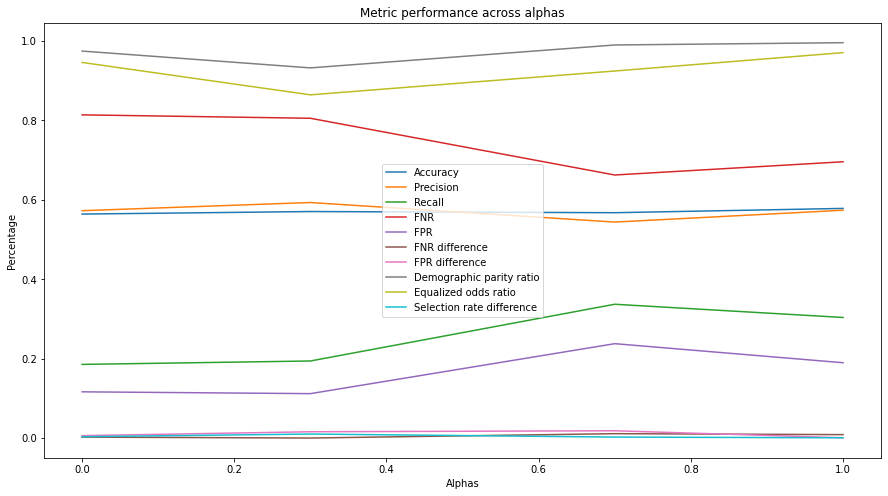

In [43]:
#@markdown ### Plot all our metrics as line plots while varying alpha
import matplotlib.pyplot as plt

metrics_dictionary
plt.figure(figsize=(15,8))

# Plot the line graph
plt.plot(metrics_dictionary['alpha'], metrics_dictionary['accuracy'],label='Accuracy')
plt.plot(metrics_dictionary['alpha'], metrics_dictionary['precision'],label='Precision')
plt.plot(metrics_dictionary['alpha'], metrics_dictionary['recall'],label='Recall')
plt.plot(metrics_dictionary['alpha'], metrics_dictionary['FNR'],label='FNR')
plt.plot(metrics_dictionary['alpha'], metrics_dictionary['FPR'],label='FPR')
plt.plot(metrics_dictionary['alpha'], metrics_dictionary['false_negative_rate_difference'],label='FNR difference')
plt.plot(metrics_dictionary['alpha'], metrics_dictionary['false_positive_rate_difference'],label='FPR difference')
plt.plot(metrics_dictionary['alpha'], metrics_dictionary['demographic_parity_ratio'],label='Demographic parity ratio')
plt.plot(metrics_dictionary['alpha'], metrics_dictionary['equalized_odds_ratio'],label='Equalized odds ratio')
plt.plot(metrics_dictionary['alpha'], metrics_dictionary['selection_rate_difference'],label='Selection rate difference')


plt.legend()

# Add labels and title to the graph
plt.xlabel('Alphas')
plt.ylabel('Percentage')
plt.title('Metric performance across alphas')

# Show the graph
plt.show()

It appears to be certain tradeoff, and accuracy is not changing much accross alphas. It might be because of the root we picked

In [45]:
import random 

sensitive_feature = X_test['gender_Female'].replace({1:'Female', 0:'Male'})

#use the alphas said in class
alphas = [0.0, 0.3, 0.7, 1.0]

#same metrics we want
metrics = {'accuracy': accuracy_score,
           'precision': precision_score,
           'recall':recall_score,
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

#initialize a dataframe
metrics_df = pd.DataFrame()

#set a dictionary for male scores
male_metrics_dictionary = {'alpha':[],
                      'accuracy':[],
                      'precision':[],
                      'recall':[],
                      'FNR':[],
                      'FPR':[]
                      }

#set a dictionary for female scores
female_metrics_dictionary = {'alpha':[],
                      'accuracy':[],
                      'precision':[],
                      'recall':[],
                      'FNR':[],
                      'FPR':[]
                      }
                  
#lets try with 10 different random seeds from 0 to 1000000      
seeds = [random.randint(0,1000000) for i in range(10)]


#Now, lets start looping
for alpha in alphas:

  male_accuracy = []
  male_precision = []
  male_recall =[]
  male_FNR =[]
  male_FPR =[]

  female_accuracy = []
  female_precision = []
  female_recall =[]
  female_FNR =[]
  female_FPR =[]

  for seed in seeds:

    model = AdversarialFairnessClassifier(backend='tensorflow',
    predictor_model=[128,64,32,16,8],
    adversary_model=[32,16,8],
    learning_rate=0.001,
    epochs=3,
    batch_size=16,
    constraints='demographic_parity',
    random_state=seed,
    shuffle=True,
    alpha = alpha)

    #set sensitivity features on the train data
    model.fit(X_train,y_train, sensitive_features = X_train['gender_Female'].replace({1:'Female',0:'Male'}))

    y_pred_baseline =model.predict(X_test)

    metric_frame = MetricFrame(metrics=metrics,
                              y_true=y_test,
                              y_pred=y_pred_baseline,
                              sensitive_features = sensitive_feature)
    
    metrics_df = metrics_df.append({'alpha' : alpha,
                                    'accuracy': metric_frame.overall['accuracy'],
                                    'precision': metric_frame.overall['precision'],
                                    'recall': metric_frame.overall['recall'],
                                    'FNR': metric_frame.overall['FNR'],
                                    'FPR': metric_frame.overall['FPR'],
                                    'false_negative_rate_difference': false_negative_rate_difference(y_test, y_pred_baseline, sensitive_features= sensitive_feature),
                                    'false_positive_rate_difference': false_positive_rate_difference(y_test, y_pred_baseline, sensitive_features= sensitive_feature),
                                    'demographic_parity_ratio': demographic_parity_ratio(y_test, y_pred_baseline, sensitive_features = sensitive_feature),
                                    'equalized_odds_ratio': equalized_odds_ratio(y_test, y_pred_baseline, sensitive_features = sensitive_feature),
                                    'selection_rate_difference': selection_rate_difference(y_test, y_pred_baseline, sensitive_features = sensitive_feature)
                                    },ignore_index=True)

    #now saving info to temporary list per seed
    male_accuracy.append(metric_frame.by_group.loc['Male'].accuracy)
    male_precision.append(metric_frame.by_group.loc['Male'].precision)
    male_recall.append(metric_frame.by_group.loc['Male'].recall)
    male_FNR.append(metric_frame.by_group.loc['Male'].FNR)
    male_FPR.append(metric_frame.by_group.loc['Male'].FPR)

    female_accuracy.append(metric_frame.by_group.loc['Female'].accuracy)
    female_precision.append(metric_frame.by_group.loc['Female'].precision)
    female_recall.append(metric_frame.by_group.loc['Female'].recall)
    female_FNR.append(metric_frame.by_group.loc['Female'].FNR)
    female_FPR.append(metric_frame.by_group.loc['Female'].FPR)

  #now we save info per alpha for group data
  #Note, no need to store the alpha since they will be stored in hirearchial order
  male_metrics_dictionary['accuracy'].append(male_accuracy)
  male_metrics_dictionary['precision'].append(male_precision)
  male_metrics_dictionary['recall'].append(male_recall)
  male_metrics_dictionary['FNR'].append(male_FNR)
  male_metrics_dictionary['FPR'].append(male_FPR)

  female_metrics_dictionary['accuracy'].append(female_accuracy)
  female_metrics_dictionary['precision'].append(female_precision)
  female_metrics_dictionary['recall'].append(female_recall)
  female_metrics_dictionary['FNR'].append(female_FNR)
  female_metrics_dictionary['FPR'].append(female_FPR)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
<ipython-input-45-a12cb81366a2>:79: FutureWarning: The frame.append m

 Plot the same metrics as above, but now using
box-and-whiskers plots to show how the metrics vary across different choices of
alpha (therefore, alpha is the x-axis; see here for example box-and-whisker code).


##First we plot for in general

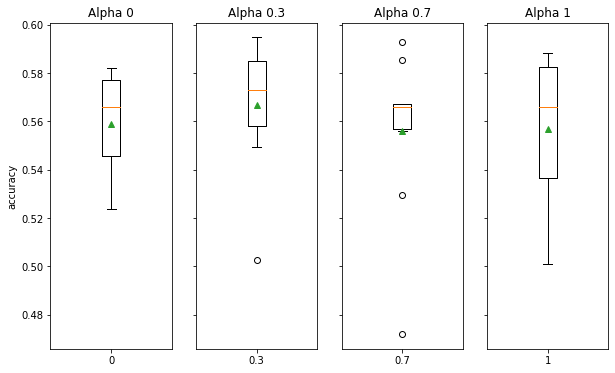

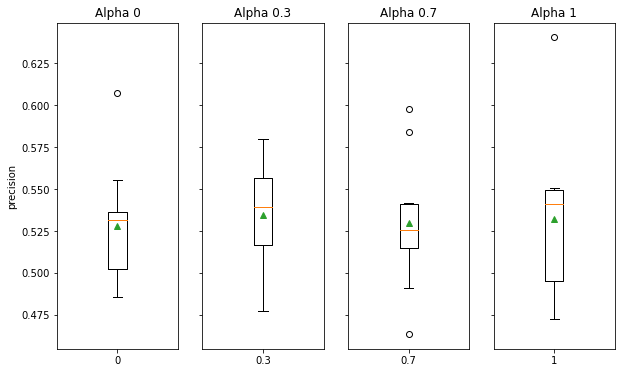

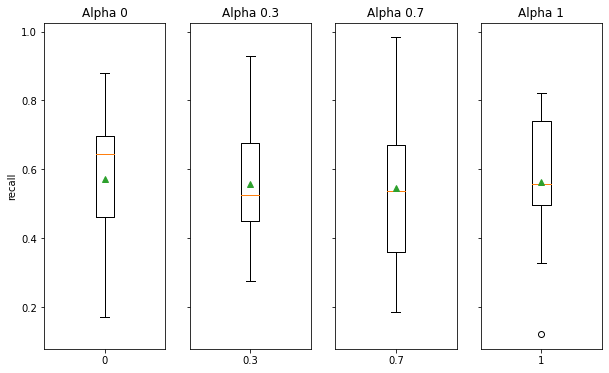

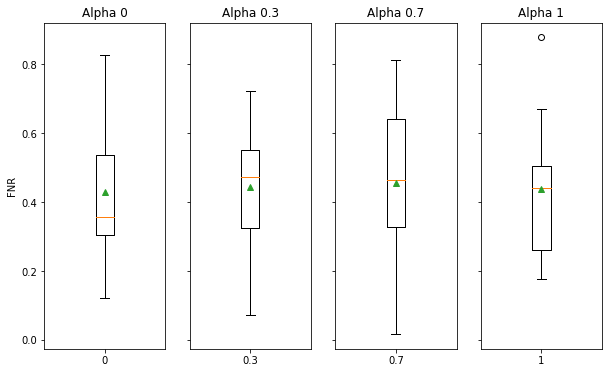

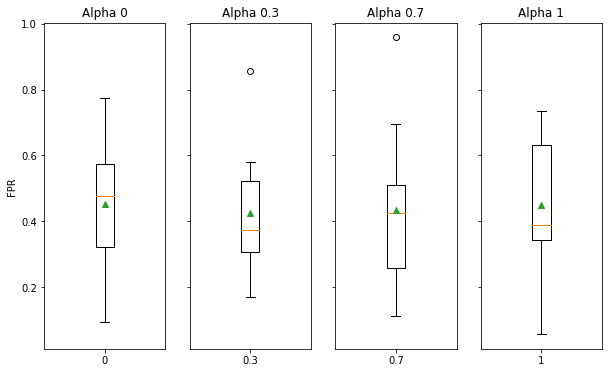

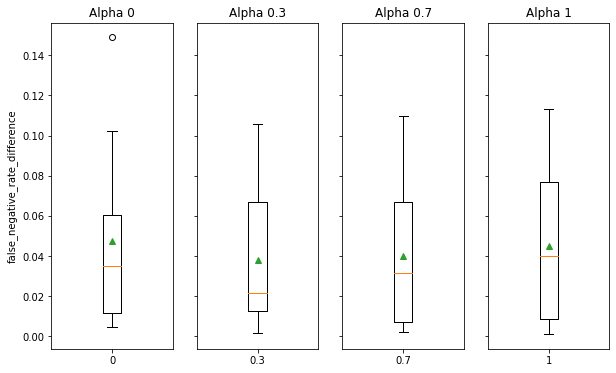

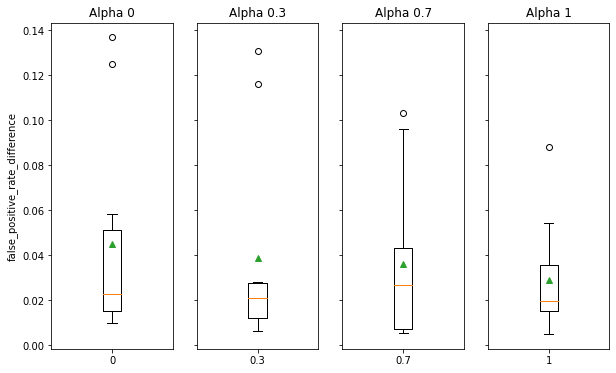

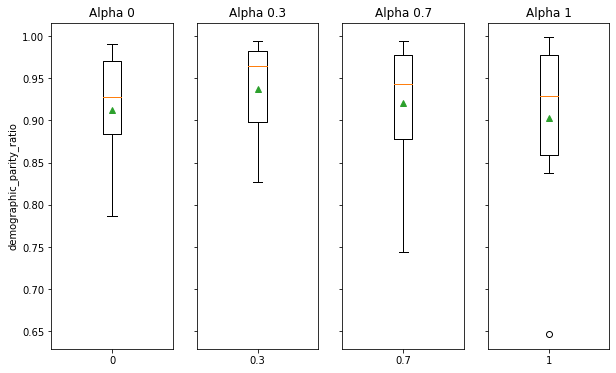

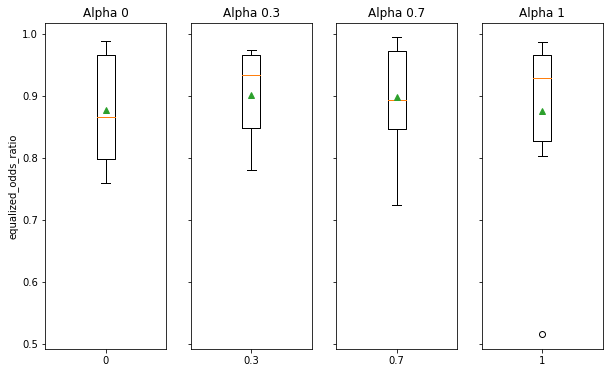

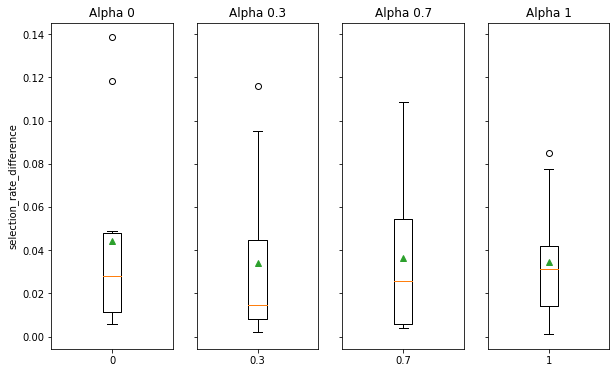

In [49]:

for col in metrics_df.columns:

  if col == 'alpha':
    continue

  fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 6), sharey=True)

  fs=10

  axs[0].title.set_text('Alpha 0')

  #lets plot the first graph with alpha = 0
  axs[0].boxplot(metrics_df[metrics_df['alpha']==0][col], showmeans=True)
  axs[0].set_xticklabels(['0'])
  axs[0].set_ylabel(col)

  #graph with alpha = 0.3
  axs[1].boxplot(metrics_df[metrics_df['alpha']==0.3][col], showmeans=True)
  axs[1].set_xticklabels(['0.3'])
  axs[1].title.set_text('Alpha 0.3')


  #graph with alpha = 0.7
  axs[2].boxplot(metrics_df[metrics_df['alpha']==0.7][col], showmeans=True)
  axs[2].set_xticklabels(['0.7'])
  axs[2].title.set_text('Alpha 0.7')


  #graph with alpha = 1
  axs[3].boxplot(metrics_df[metrics_df['alpha']==1][col], showmeans=True)
  axs[3].set_xticklabels(['1'])
  axs[3].title.set_text('Alpha 1')


  fig.subplots_adjust(hspace=0.4)
  plt.show()

##First we plot for Males

For males


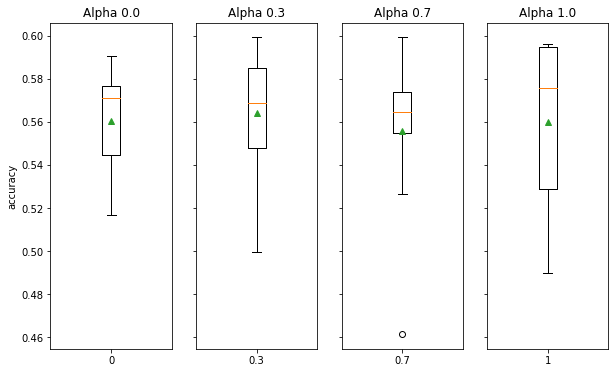

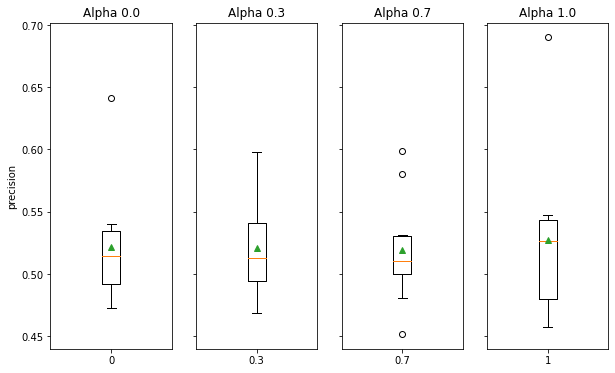

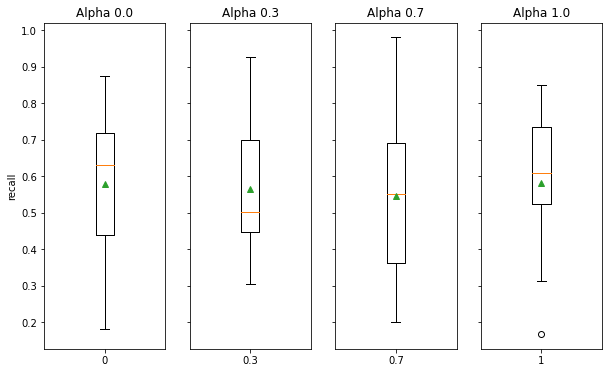

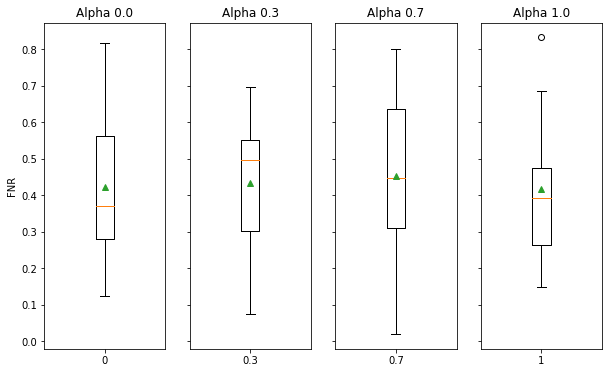

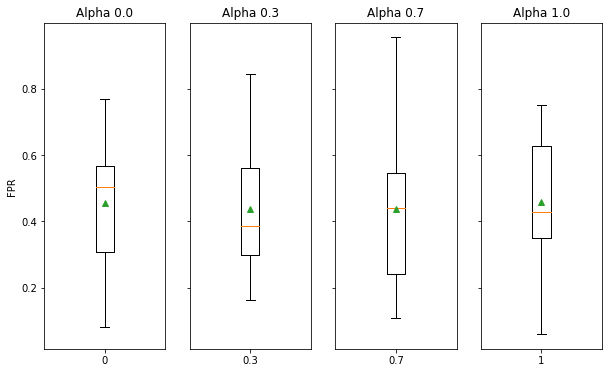

In [51]:
# plots for the male data 
print("For males")
for key,values in male_metrics_dictionary.items():

  if key =='alpha':
    continue

  fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 6), sharey=True)
  fs=10

  #lets plot for alpha = 0
  axs[0].boxplot(values[0], showmeans=True)
  axs[0].set_xticklabels(['0'])
  axs[0].set_ylabel(key)
  axs[0].title.set_text('Alpha 0.0')


  #now for alpha = 0.3
  axs[1].boxplot(values[1], showmeans=True)
  axs[1].set_xticklabels(['0.3'])
  axs[1].title.set_text('Alpha 0.3')

  #now for alpha = 0.7
  axs[2].boxplot(values[2], showmeans=True)
  axs[2].set_xticklabels(['0.7'])
  axs[2].title.set_text('Alpha 0.7')

  #now for alpha = 1
  axs[3].boxplot(values[3], showmeans=True)
  axs[3].set_xticklabels(['1'])
  axs[3].title.set_text('Alpha 1.0')


  fig.subplots_adjust(hspace=0.4)
  plt.show()
  

##Then we plot for females

for females


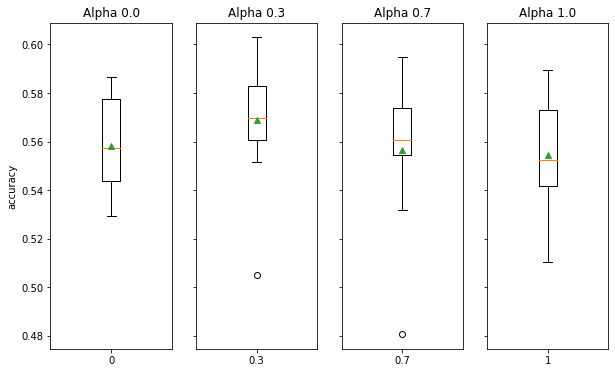

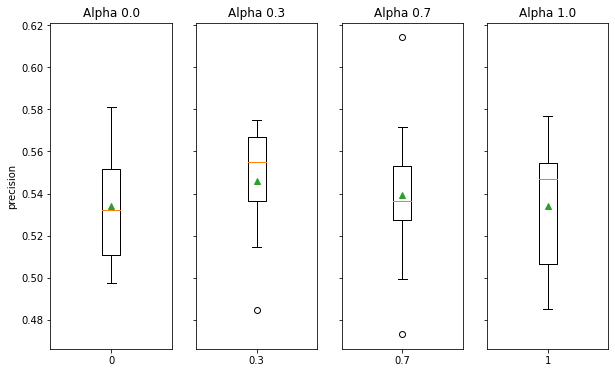

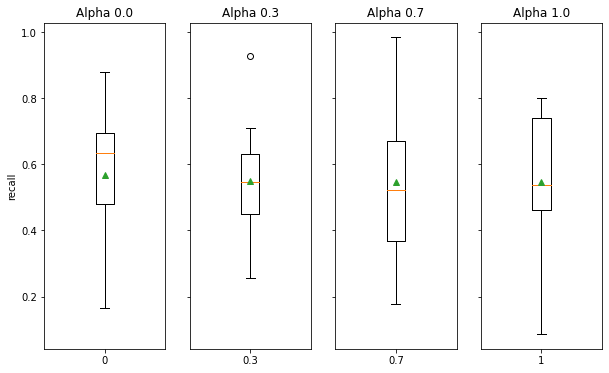

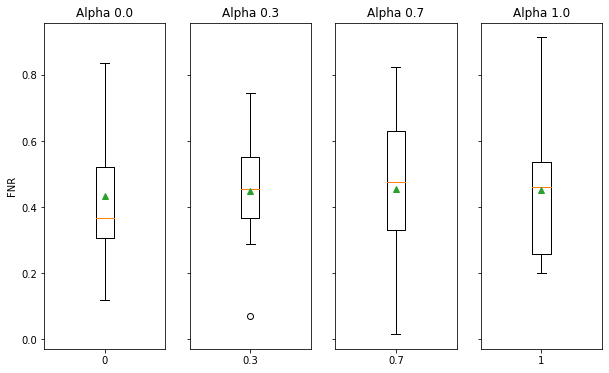

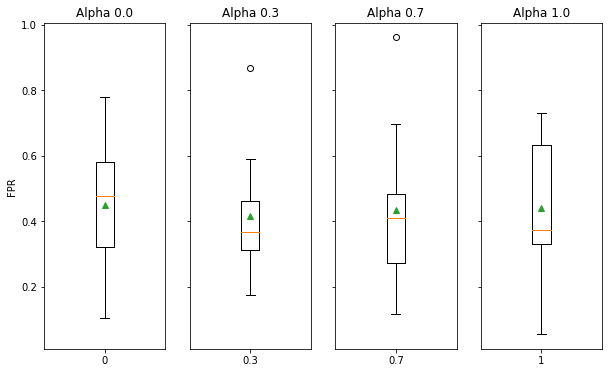

In [52]:
# plots for the female data 

print("for females")

for key,values in female_metrics_dictionary.items():

  if key =='alpha':
    continue

  fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 6), sharey=True)
  fs=10

  #lets plot for alpha = 0
  axs[0].boxplot(values[0], showmeans=True)
  axs[0].set_xticklabels(['0'])
  axs[0].set_ylabel(key)
  axs[0].title.set_text('Alpha 0.0')

  #now for alpha = 0.3
  axs[1].boxplot(values[1], showmeans=True)
  axs[1].set_xticklabels(['0.3'])
  axs[1].title.set_text('Alpha 0.3')

  #now for alpha = 0.7
  axs[2].boxplot(values[2], showmeans=True)
  axs[2].set_xticklabels(['0.7'])
  axs[2].title.set_text('Alpha 0.7')

  #now for alpha = 1
  axs[3].boxplot(values[3], showmeans=True)
  axs[3].set_xticklabels(['1'])
  axs[3].title.set_text('Alpha 1.0')


  fig.subplots_adjust(hspace=0.4)
  plt.show()

In [54]:
metrics_df

,alpha,accuracy,precision,recall,FNR,FPR,false_negative_rate_difference,false_positive_rate_difference,demographic_parity_ratio,equalized_odds_ratio,selection_rate_difference
0,0.0,0.570727,0.607547,0.172932,0.827068,0.094118,0.017097,0.022522,0.953274,0.784589,0.006213
1,0.0,0.524067,0.488650,0.878625,0.121375,0.774661,0.004857,0.009558,0.988273,0.987732,0.009693
2,0.0,0.541749,0.499216,0.684211,0.315789,0.578281,0.009629,0.018487,0.973562,0.968497,0.016770
3,0.0,0.582024,0.555249,0.431794,0.568206,0.291403,0.063022,0.022558,0.882752,0.862882,0.044034
4,0.0,0.577603,0.532539,0.624060,0.375940,0.461538,0.102321,0.124862,0.799611,0.759601,0.118109
5,0.0,0.523576,0.485693,0.711063,0.288937,0.634389,0.025061,0.029817,0.962029,0.954155,0.025958
6,0.0,0.575639,0.534572,0.556391,0.443609,0.408145,0.044970,0.058340,0.902568,0.867244,0.048980
7,0.0,0.556974,0.511390,0.699248,0.300752,0.562896,0.007009,0.010181,0.990859,0.982088,0.005744
8,0.0,0.561395,0.536680,0.298604,0.701396,0.217195,0.053467,0.013817,0.888999,0.837222,0.030065
9,0.0,0.577603,0.530472,0.663802,0.336198,0.495023,0.148882,0.136656,0.786300,0.759560,0.138453


##Discuss in your report how these results compare with the metrics from the tuned random forest model from (b).

We see that our results appear to be a little bit better in general in terms of accuracy in comparison to our tunned model in part b, but in terms of false positive and false negative rates between male and females, aside from still having certain difference between them (meaning parity is not that high), they appear to be in high levels, so this model is not completely outperforming the one we had in part b. However, we should think that there might be one of the 40 models that is outperforming our tunned random forest, but it is not that clear from these graphs. We do see a higher demographic_parity_ratio, and false_positive_rate_difference falling to 0.009 in an instance, so the model is indeed stronger in giving us these fair tradeoffs with a safe promise of getting a fairer model. Honestly, I think that the seeds weren't the best, and further hyperparameting could substantially improve our results in comparison to part b




# Problem 2, Part (d) 
### **Threshold Optimizer Post-processing intervention**



In [92]:
#@markdown Fit the ThresholdOptimizer model here
# Fit the ThresholdOptimizer model here

#fixed estimators
n_estimators = 1000
max_depth = 10

sensitive_feature = X_test['gender_Female'].replace({1:'Female', 0:'Male'})


#lets set up the dict to save our findings
threshold_metrics_dictionary = {'alpha':[],
                      'accuracy':[],
                      'precision':[],
                      'recall':[],
                      'FNR':[],
                      'FPR':[],
                      'false_negative_rate_difference':[],
                      'false_positive_rate_difference':[],
                      'demographic_parity_ratio':[],
                      'equalized_odds_ratio':[],
                      'selection_rate_difference':[]
                      }

#one for males
threshold_male_metrics_dictionary = {'alpha':[],
                      'accuracy':[],
                      'precision':[],
                      'recall':[],
                      'FNR':[],
                      'FPR':[],
                      }
#another for females
threshold_female_metrics_dictionary = {'alpha':[],
                      'accuracy':[],
                      'precision':[],
                      'recall':[],
                      'FNR':[],
                      'FPR':[],
                      }

#lets start the recalibration process

for i in range(10):

  X_train, X_test, y_train, y_test = train_test_split(x_numeric, y_raw, test_size=0.2)
  default_model = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)

  # Train the classifier using the training data
  default_model.fit(X_train, y_train)

  # Make the post-processed model
  postprocessed_model = ThresholdOptimizer(
      estimator=default_model,
      constraints='selection_rate_parity',
      objective='balanced_accuracy_score',
      prefit=True,
      predict_method='predict_proba'
  )

  # Fit the model to the training data
  postprocessed_model.fit(X_train, y_train, sensitive_features = X_train['gender_Female'])

  # Predict on the test data
  y_pred_to = postprocessed_model.predict(X_test, sensitive_features = X_test['gender_Female'])  

  # Make a metricframe
  metrics_frame = MetricFrame(
      metrics=metrics,
      y_true=y_test,
      y_pred=y_pred_to,
      sensitive_features=X_test['gender_Female'].replace({1:'Female',0:'Male'}))
  
  #for regular ones
  threshold_metrics_dictionary['accuracy'].append(metrics_frame.overall['accuracy'])
  threshold_metrics_dictionary['precision'].append(metrics_frame.overall['precision'])
  threshold_metrics_dictionary['recall'].append(metrics_frame.overall['recall'])
  threshold_metrics_dictionary['FNR'].append(metrics_frame.overall['FNR'])
  threshold_metrics_dictionary['FPR'].append(metrics_frame.overall['FPR'])

  #for the ones we need a function for
  threshold_metrics_dictionary['false_negative_rate_difference'].append(false_negative_rate_difference(y_test, y_pred_to, sensitive_features= sensitive_feature))
  threshold_metrics_dictionary['false_positive_rate_difference'].append(false_positive_rate_difference(y_test, y_pred_to, sensitive_features= sensitive_feature))
  threshold_metrics_dictionary['demographic_parity_ratio'].append(demographic_parity_ratio(y_test, y_pred_to, sensitive_features= sensitive_feature))
  threshold_metrics_dictionary['equalized_odds_ratio'].append(equalized_odds_ratio(y_test, y_pred_to, sensitive_features= sensitive_feature))
  threshold_metrics_dictionary['selection_rate_difference'].append(selection_rate_difference(y_test, y_pred_to, sensitive_features= sensitive_feature))

  #reporting for males
  threshold_male_metrics_dictionary['accuracy'].append(metrics_frame.by_group.loc['Male'].accuracy)
  threshold_male_metrics_dictionary['precision'].append(metrics_frame.by_group.loc['Male'].precision)
  threshold_male_metrics_dictionary['recall'].append(metrics_frame.by_group.loc['Male'].recall)
  threshold_male_metrics_dictionary['FNR'].append(metrics_frame.by_group.loc['Male'].FNR)
  threshold_male_metrics_dictionary['FPR'].append(metrics_frame.by_group.loc['Male'].FPR)

  #reporting for females
  threshold_female_metrics_dictionary['accuracy'].append(metrics_frame.by_group.loc['Female'].accuracy)
  threshold_female_metrics_dictionary['precision'].append(metrics_frame.by_group.loc['Female'].precision)
  threshold_female_metrics_dictionary['recall'].append(metrics_frame.by_group.loc['Female'].recall)
  threshold_female_metrics_dictionary['FNR'].append(metrics_frame.by_group.loc['Female'].FNR)
  threshold_female_metrics_dictionary['FPR'].append(metrics_frame.by_group.loc['Female'].FPR)

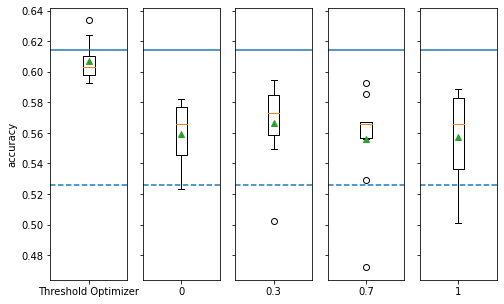

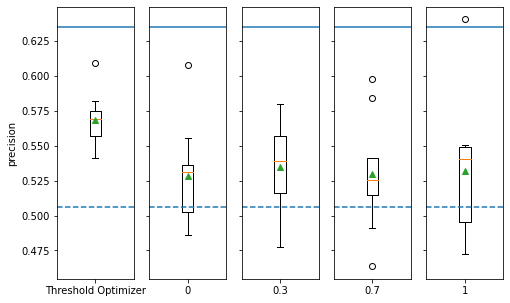

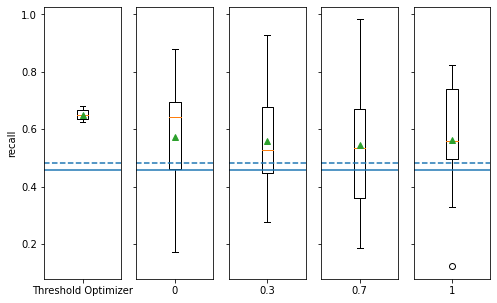

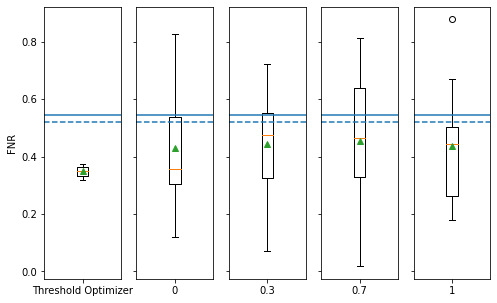

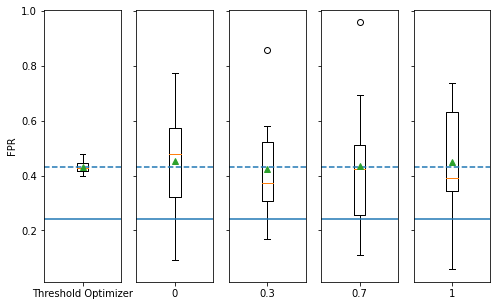

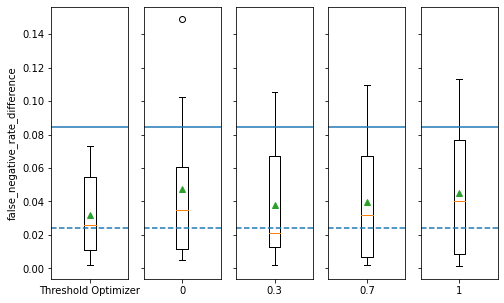

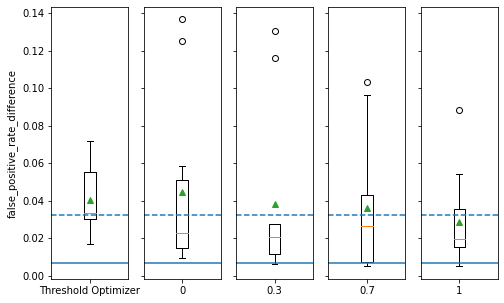

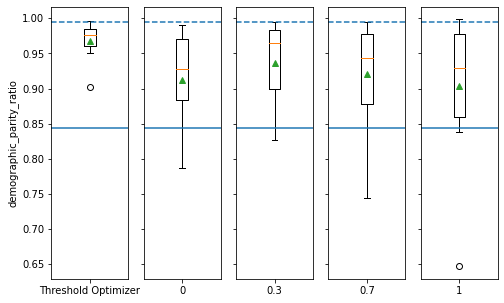

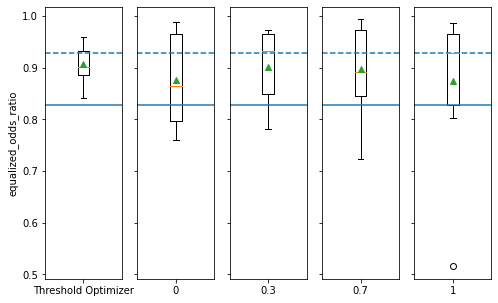

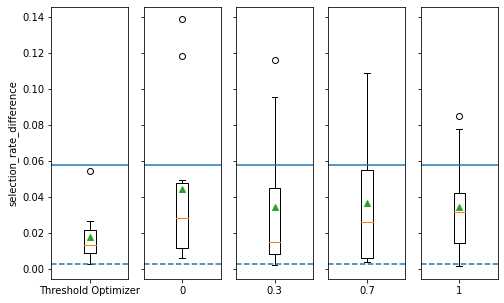

In [93]:
for col in metrics_df.columns:
  if col == 'alpha':
    continue
  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(8, 5), sharey=True)
  fs=10
  
  axs[0].boxplot(threshold_metrics_dictionary[col], showmeans=True)
  axs[0].set_xticklabels(['Threshold Optimizer'])
  axs[0].set_ylabel(col)
  axs[0].set_ylabel(col)
  axs[0].axhline(y = tuned_forest[col],linestyle ="-")
  axs[0].axhline(y = untuned_forest[col],linestyle ="--")

  # Set the x-axis tick labels
  axs[1].boxplot(metrics_df[metrics_df['alpha']==0][col], showmeans=True)
  axs[1].set_xticklabels(['0'])
  axs[1].axhline(y = tuned_forest[col],linestyle ="-")
  axs[1].axhline(y = untuned_forest[col],linestyle ="--")

  axs[2].boxplot(metrics_df[metrics_df['alpha']==0.3][col], showmeans=True)
  axs[2].set_xticklabels(['0.3'])
  axs[2].axhline(y = tuned_forest[col],linestyle ="-")
  axs[2].axhline(y = untuned_forest[col],linestyle ="--")


  axs[3].boxplot(metrics_df[metrics_df['alpha']==0.7][col], showmeans=True)
  axs[3].set_xticklabels(['0.7'])
  axs[3].axhline(y = tuned_forest[col],linestyle ="-")
  axs[3].axhline(y = untuned_forest[col],linestyle ="--")


  axs[4].boxplot(metrics_df[metrics_df['alpha']==1][col], showmeans=True)
  axs[4].set_xticklabels(['1'])
  axs[4].axhline(y = tuned_forest[col],linestyle ="-")
  axs[4].axhline(y = untuned_forest[col],linestyle ="--")


  fig.subplots_adjust(hspace=0.4)
  plt.show()

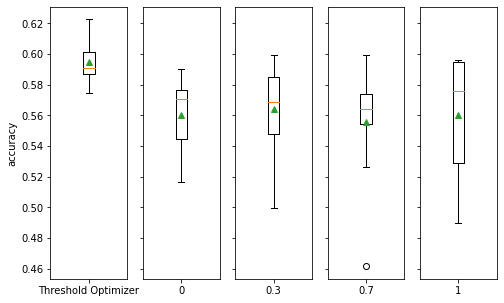

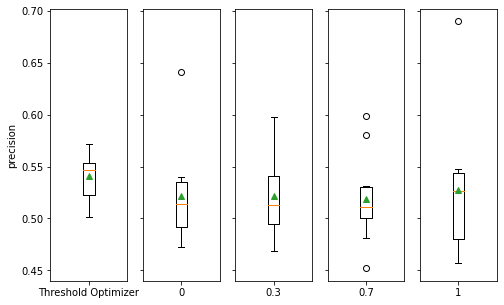

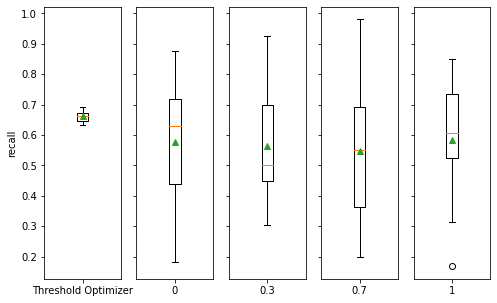

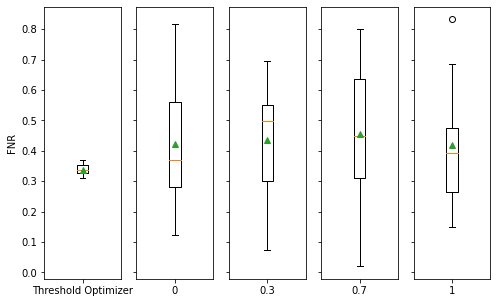

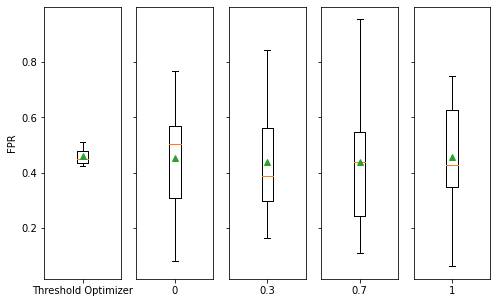

In [94]:
# male group data 
for key,values in male_metrics_dictionary.items():
  if key =='alpha':
    continue

  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(8, 5), sharey=True)
  fs=10

  axs[0].boxplot(threshold_male_metrics_dictionary[key], showmeans=True)
  axs[0].set_xticklabels(['Threshold Optimizer'])
  axs[0].set_ylabel(col)
  axs[0].set_ylabel(key)

  # Set the x-axis tick labels
  axs[1].boxplot(values[0], showmeans=True)
  axs[1].set_xticklabels(['0'])
  

  axs[2].boxplot(values[1], showmeans=True)
  axs[2].set_xticklabels(['0.3'])


  axs[3].boxplot(values[2], showmeans=True)
  axs[3].set_xticklabels(['0.7'])


  axs[4].boxplot(values[3], showmeans=True)
  axs[4].set_xticklabels(['1'])

  fig.subplots_adjust(hspace=0.4)
  plt.show()

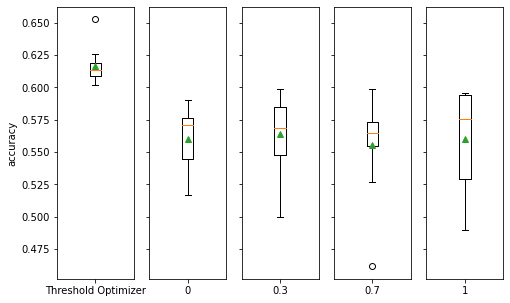

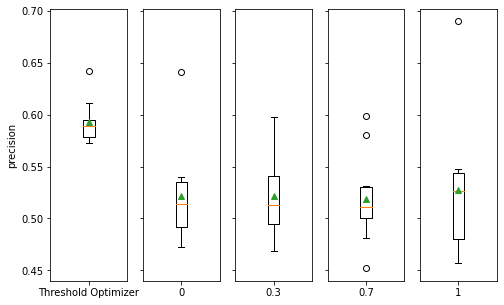

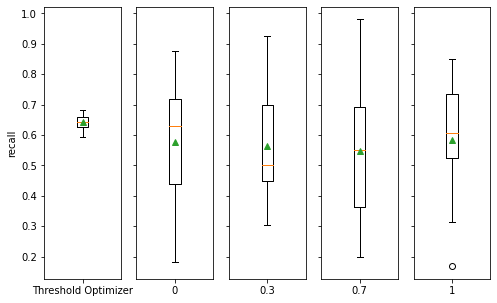

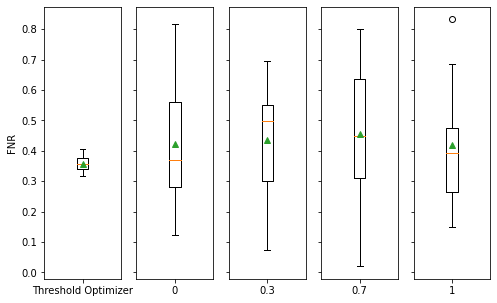

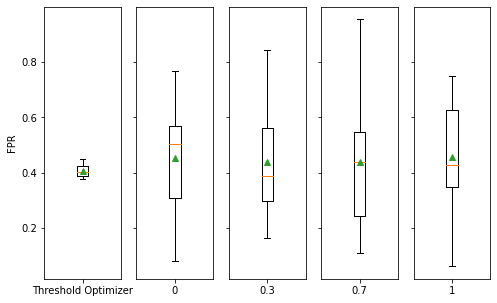

In [95]:
# female group data 
for key,values in male_metrics_dictionary.items():
  if key =='alpha':
    continue

  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(8, 5), sharey=True)
  fs=10

  axs[0].boxplot(threshold_female_metrics_dictionary[key], showmeans=True)
  axs[0].set_xticklabels(['Threshold Optimizer'])
  axs[0].set_ylabel(col)
  axs[0].set_ylabel(key)

  # Set the x-axis tick labels
  axs[1].boxplot(values[0], showmeans=True)
  axs[1].set_xticklabels(['0'])
  

  axs[2].boxplot(values[1], showmeans=True)
  axs[2].set_xticklabels(['0.3'])


  axs[3].boxplot(values[2], showmeans=True)
  axs[3].set_xticklabels(['0.7'])


  axs[4].boxplot(values[3], showmeans=True)
  axs[4].set_xticklabels(['1'])

  fig.subplots_adjust(hspace=0.4)
  plt.show()

In [96]:
metrics_frame

Conclude your report with any general observations about the trends and trade-offs you
observed in the performance of the fairness enhancing interventions with respect to the
accuracy and fairness metrics.


After intervention in this last part, we see that accuracy in the model from part b was still competitive (expected, is the same). So lets focus on the fairness part. This one has a better performance in terms of FNR, but performs not that great in comparison in FPR. Then, when we go to see the rest of the graphs, we see that our model only outperforms the rest in equalized odds ratio and demographic parity (by what looks like an outlier in alpha 0.7). So we will have to pick that specific model with alpha 0.7 and compare it a little bit more in depth with the one in part b in order to see how better we got testing the best models. But in a nutshell, it does look like it improved the model from part b, but not by an outstanding amount. Maybe we should try pre processing methods in order to reduce bias in that case.

Now, in terms of general observations, we do see that hypertunning correctly with random forest drives to pretty solid outcomes, and further hypertunning with pre and post fairness techniques can help us sustantially in making a reliable clasiffier model. Fairness enhancing interventions did not, however, increase the accuracy of our models sustantially, but it gave us more certainty that the model will not go out of bounds in terms of achieving a somewhat fairer model. 
